In [1]:
import sympy as sp
from IPython.display import display, Math
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def disp(expression):
    """This function is for easy display of sympy stuff"""
    display(Math(sp.latex(expression)))

Now, define some useful matrices

In [3]:
beta, gamma = sp.symbols('β γ')

I_3 = sp.Matrix([[1, 0, 0], 
                 [0, 1, 0], 
                 [0, 0, 1]])

Rx = sp.Matrix([[1,      0,              0       ], 
                [0, sp.cos(gamma), -sp.sin(gamma)], 
                [0, sp.sin(gamma),  sp.cos(gamma)]])

Ry = sp.Matrix([[sp.cos(beta),  0, sp.sin(beta)],
                [      0,       1,        0    ],
                [-sp.sin(beta), 0, sp.cos(beta)]])

In [4]:
# make objects for the DBC and the chip. The DBC is an infinite flat plane along x-y. The chip is a rectangle with the length along the x-axis, the width along the y-axis, and with the x-axis normal to the surface. The chip is located above the DBC, and has some rotation applied along its x and y axes.
chip_height = sp.symbols('h_c')
chip_position = sp.Matrix([[0], [0], [chip_height]])
chip_coord_sys = Rx * Ry * I_3

DBC_position = sp.Matrix([[0], [0], [0]])
DBC_norm_vec_endpoint = sp.Matrix([[0], [0], [1]])

# now, shift the whole system down so that the chip is at the origin
chip_position = sp.Matrix([[0], [0], [0]])
DBC_position = sp.Matrix([[0], [0], [-chip_height]])
DBC_norm_vec_endpoint = sp.Matrix([[0], [0], [1-chip_height]])

# get the reverse rotation matrices using the fact that the inverse of a rotation matrix is its transpose
Rx_inv = sp.transpose(Rx)
Ry_inv = sp.transpose(Ry)

# Now rotate the whole system to re-align the chip
chip_coord_sys = sp.simplify(Ry_inv * Rx_inv * chip_coord_sys)
DBC_position = Ry_inv * Rx_inv * DBC_position
DBC_norm_vec_endpoint = Ry_inv * Rx_inv * DBC_norm_vec_endpoint

# calculate the normal vector and use it to form a plane
x, y, z, Z_0 = sp.symbols('x y z Z_0')
DBC_norm_vec = sp.simplify(DBC_norm_vec_endpoint - DBC_position)
DBC_plane = sp.Eq(DBC_norm_vec[0]*x + DBC_norm_vec[1]*y + DBC_norm_vec[2]*z, Z_0)

# solve for z to get a function for the plane in terms of x and y
DBC_func = sp.solve(DBC_plane, z)[0]

# use the fact that the DBC_position point is located on the plane to solve for Z_0
eqn = sp.Eq(DBC_func.subs({x:DBC_position[0], y:DBC_position[1]}), DBC_position[2])
new_Z_0 = sp.solve(eqn, Z_0)[0]
DBC_func = DBC_func.subs({Z_0:new_Z_0})

# make a function h(x,y) for the height of the solder layer at (x,y). This is just the distance from the x-y plane (where the chip is currently located) to the DBC plane. Since the DBC is below the x-axis, h(x,y) is just the negative of the DBC plane.
h = -DBC_func

# thermal conductivity has the form Y = kA/h, where k is the material conductivity, A is the area of contact, and h is the height of the material. The differential form is then dY = k*dA / h(x,y). This just needs to be integrated along x and y to obtain the thermal conductivity.
L, W, k = sp.symbols('L W k')

Yth = sp.integrate(k/h, (x, -L/2, L/2), (y, -W/2, W/2))

Rth = sp.simplify(1/Yth)

In [26]:
# give the parameters values for the plot
length = 5E-3
width = 3E-3
height = 0.1E-3
conductivity = 58.7
Rth_plottable = sp.simplify(Rth.subs({L:length, 
                                      W:width, 
                                      chip_height:height,    
                                      k:conductivity}))

# now plot it where gamma is along x (rows) and beta is along y (columns)
resolution = 30
gamma_vals_degrees = np.linspace(-4, 4, resolution) #DEGREES
beta_vals_degrees = np.linspace(-4, 4, resolution) #DEGREES

gamma_vals = gamma_vals_degrees * 2*np.pi/360
beta_vals = beta_vals_degrees * 2*np.pi/360


Rth_vals = np.zeros((len(gamma_vals), len(beta_vals)), dtype='float')

for i, gam in enumerate(gamma_vals):
    for j, bet in enumerate(beta_vals):

        # check to see if the value is imaginary, if so, that means the chip is intersecting with the DBC
        temp = Rth_plottable.subs({gamma:gam, beta:bet})
        real_part = sp.re(temp)
        im_part = sp.im(temp)
        small_step = 1E-10
        if (im_part < -small_step) or (im_part > small_step):
            Rth_vals[i, j] = None
        else:
            Rth_vals[i, j] = real_part

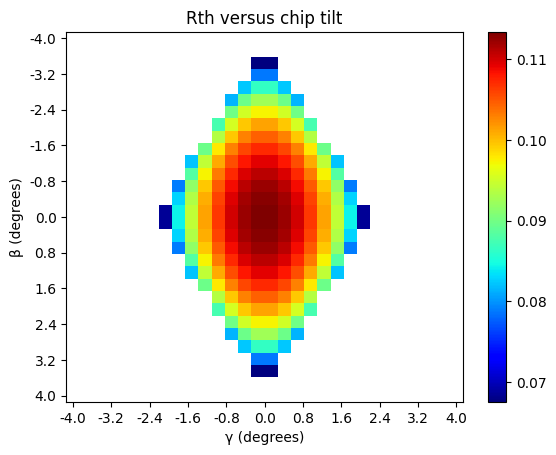

In [27]:
# now I can finally plot it
fig, ax = plt.subplots()

ax.set_title('Rth versus chip tilt')

ax = plt.imshow(Rth_vals, cmap='jet', interpolation='nearest', aspect='auto')
plt.colorbar()

num_ticks = 11
plt_axes = ax.axes
plt_axes.set_xlabel('γ (degrees)')
plt_axes.set_ylabel('β (degrees)')

# add ticks to the x-axis
xtickvals = np.ndarray.tolist(np.linspace(min(gamma_vals_degrees), max(gamma_vals_degrees), num_ticks))
xlabels = list()
for fp in xtickvals:
    xlabels.append('%.1f' % fp)
plt_axes.set_xticks(np.linspace(0, len(gamma_vals)-1, num_ticks), xlabels)

# add ticks to the y-axis
ytickvals = np.ndarray.tolist(np.linspace(min(beta_vals_degrees), max(beta_vals_degrees), num_ticks))
ylabels = list()
for fp in ytickvals:
    ylabels.append('%.1f' % fp)
plt_axes.set_yticks(np.linspace(0, len(beta_vals)-1, num_ticks), ylabels)

# Show the plot
plt.show()

In [28]:
disp(Rth)

<IPython.core.display.Math object>

In [29]:
print(Rth)

2*sin(γ)*tan(β)/(k*(W*(log(-L*sin(β)*cos(γ)/2 - W*sin(γ)/2 - h_c) + log(-L*sin(β)*cos(γ)/2 + W*sin(γ)/2 - h_c) - log(L*sin(β)*cos(γ)/2 - W*sin(γ)/2 - h_c) - log(L*sin(β)*cos(γ)/2 + W*sin(γ)/2 - h_c))*sin(γ) - (L*sin(β)*cos(γ) - 2*h_c)*log(-L*sin(β)/(2*tan(γ)) - W/2 + h_c/sin(γ)) + (L*sin(β)*cos(γ) - 2*h_c)*log(-L*sin(β)/(2*tan(γ)) + W/2 + h_c/sin(γ)) - (L*sin(β)*cos(γ) + 2*h_c)*log(L*sin(β)/(2*tan(γ)) - W/2 + h_c/sin(γ)) + (L*sin(β)*cos(γ) + 2*h_c)*log(L*sin(β)/(2*tan(γ)) + W/2 + h_c/sin(γ))))
